In [10]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
data_path = '../data/train'
train_df = pd.read_csv(os.path.join(data_path, 'train_ratings.csv')) # 전체 학습 데이터

In [3]:
train_df.head(10)

,user,item,time
0,11,4643,1230782529
1,11,170,1230782534
2,11,531,1230782539
3,11,616,1230782542
4,11,2140,1230782563
5,11,2722,1230782583
6,11,2313,1230782646
7,11,2688,1230782656
8,11,2428,1230782694
9,11,3113,1230782719


In [4]:
num_train_users = train_df['user'].nunique()
num_train_items = train_df['item'].nunique()

print ("Number of unique train users: ", num_train_users)
print ("Number of unique train items: ", num_train_items)
print("Data sparsity ratio: ", 1 - len(train_df) / (num_train_users * num_train_items))

Number of unique train users:  31360
Number of unique train items:  6807
Data sparsity ratio:  0.9758536052697853


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [6]:
user_lb = LabelEncoder()
item_lb = LabelEncoder()
train_df['user_idx'] = user_lb.fit_transform(train_df['user'].values)
train_df['item_idx'] = item_lb.fit_transform(train_df['item'].values)

In [7]:
train_df

,user,item,time,user_idx,item_idx
0,11,4643,1230782529,0,2505
1,11,170,1230782534,0,109
2,11,531,1230782539,0,319
3,11,616,1230782542,0,368
4,11,2140,1230782563,0,1183
...,...,...,...,...,...
5154466,138493,44022,1260209449,31359,4882
5154467,138493,4958,1260209482,31359,2652
5154468,138493,68319,1260209720,31359,5768
5154469,138493,40819,1260209726,31359,4791


In [8]:
"""import numpy as np
import pandas as pd
import os
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder


def filter(df, min_user_count, min_item_count):
    item_count = df['item'].nunique()
    user_count = df['user'].nunique()
    return df, user_count, item_count


def numerize(df, user2id):
    
    uid = list(map(lambda x: user2id[x], df['uid']))
    df['uid_new'] = uid
    
    le1 = LabelEncoder()
    id_lists = df["iid"].unique().tolist() + ["unknown"]
    le1.fit(id_lists)
    df['iid_new'] = df['iid']
    iid_new = le1.transform(df['iid_new'].astype(str))
    df['iid_new'] = iid_new
    
    return df

def __make_user_item_interaction(config, train_df, test_df):
    print('data preprocessing...')

    df = pd.concat([train_df, test_df])

    df = df.sort_values(by=["userID", "Timestamp"], axis=0) 

    df.rename(columns={'userID': 'uid', 'assessmentItemID': 'iid', 'answerCode': 'rating'}, inplace=True) # userID를 user로 assessmentID를 item으로 answerCode를 rating으로 생각하기 위해 컬럼명 변경 

    df, user_count, item_count = filter(df, min_user_count=20, min_item_count=20) # 최소 사용자 수와 최소 아이템 수를 충족시키지 않은 행을 제거 후 df, 사용자 수, 아이템 수를 반환
                                                                                  # 일단은 20으로 설정

    sparsity = float(df.shape[0]) / user_count.shape[0] / item_count.shape[0]
    print('num_user: %d, num_item: %d, num_interaction: %d, sparsity: %.4f%%' % (user_count.shape[0], item_count.shape[0], df.shape[0], sparsity * 100))

    unique_uid = user_count.index
    user2id = dict((uid, i) for (i, uid) in enumerate(unique_uid))
    all_df = numerize(df, user2id)

    print('data splitting...')

    all_df_sorted = all_df.sort_values(by=['uid_new', 'Timestamp', 'iid_new'])

    users = np.array(all_df_sorted['uid_new'], dtype=np.int32)
    items = np.array(all_df_sorted['iid_new'], dtype=np.int32)

    all_data = defaultdict(list) # 딕셔너리에 새로운 원소를 쉽게 추가하기 위해 defaultdict로 바꿈
    for n in range(len(users)):
        all_data[users[n]].append(items[n]) # user-item interaction dict

    train_dict = dict()

    for u in all_data:
        train_dict[u] = all_data[u][:-2]


    print('preprocessed data save')
    
    data_dir = config['data_loader']['args']['data_dir']
    np.save(os.path.join(data_dir, 'preprocessed_data'), np.array([train_dict, max(users) + 1, max(items) + 1]))
    tag_df_sorted = all_df.sort_values(by=['KnowledgeTag_new', 'iid_new'])
    grouped_tag = tag_df_sorted.groupby('KnowledgeTag_new').apply(lambda r: list(set(r['iid_new'].values)))
    rel_dict = grouped_tag.to_dict()
    np.save(os.path.join(data_dir, 'preprocessed_data_rel'), np.array([rel_dict]))
    
    print('Making user-item interaction dict is done.')

    return train_dict, rel_dict"""

'import numpy as np\nimport pandas as pd\nimport os\nfrom collections import defaultdict\nfrom sklearn.preprocessing import LabelEncoder\n\n\ndef filter(df, min_user_count, min_item_count):\n    item_count = df[\'item\'].nunique()\n    user_count = df[\'user\'].nunique()\n    return df, user_count, item_count\n\n\ndef numerize(df, user2id):\n    \n    uid = list(map(lambda x: user2id[x], df[\'uid\']))\n    df[\'uid_new\'] = uid\n    \n    le1 = LabelEncoder()\n    id_lists = df["iid"].unique().tolist() + ["unknown"]\n    le1.fit(id_lists)\n    df[\'iid_new\'] = df[\'iid\']\n    iid_new = le1.transform(df[\'iid_new\'].astype(str))\n    df[\'iid_new\'] = iid_new\n    \n    return df\n\ndef __make_user_item_interaction(config, train_df, test_df):\n    print(\'data preprocessing...\')\n\n    df = pd.concat([train_df, test_df])\n\n    df = df.sort_values(by=["userID", "Timestamp"], axis=0) \n\n    df.rename(columns={\'userID\': \'uid\', \'assessmentItemID\': \'iid\', \'answerCode\': \'ratin

In [9]:
class MovieLensDataset(Dataset):
    def __init__(self, df, train_size=0.8, train=False):
        self.df = df
        self.train = train
        self.train_size = train_size
        self.test_size = 1 - self.train_size 

        self.num_items = len(self.df['user_idx'].unique())
        self.num_users = len(self.df['user_idx'].unique())

        self.train_df, self.test_df = train_test_split(self.df, test_size=self.test_size, train_size=self.train_size, stratify = self.df['user_idx'].values, random_state=42)

        if self.train == True:
            self.df = self.train_df
        else:
            self.df = self.test_df

        self.users = torch.tensor(self.df['user_idx'].values)
        self.items = torch.tensor(self.df['item_idx'].values)
        
        self.interaction_mat = self.make_interaction()
    
    def make_interaction(self):
        interaction_mat = np.zeros((self.num_items, self.num_users))
        for user, item in zip(self.users, self.items):
            interaction_mat[item][user] = 1

        return interaction_mat

    def __len__(self):
        return len(self.interaction_mat)

    def __getitem__(self, index):
        interaction_mat = torch.tensor(self.interaction_mat[index]).float()

        return interaction_mat

In [10]:
class AutoRec(nn.Module):
    def __init__(self, num_hidden, num_users, dropout=0.05):
        super(AutoRec, self).__init__()
        self.encoder = nn.Linear(num_users, num_hidden)
        self.sigmoid = nn.Sigmoid()
        self.decoder = nn.Linear(num_hidden, num_users)
        self.dropout = nn.Dropout(dropout)

    def forward(self, mat):
        hidden = self.dropout(self.sigmoid(self.encoder(mat)))
        pred = self.decoder(hidden)
        
        return pred
     

In [11]:

def trainer(model, train_iter, loss, optm, device):
    model.train() # to train mode
    loss_sum = 0

    for inter_mat in train_iter:
        inter_mat = inter_mat.to(device)    

        preds = model(inter_mat)
        loss_out = loss(preds, inter_mat)

        # Update
        optm.zero_grad() # reset gradient 
        loss_out.backward() # backpropagate
        optm.step() # optimizer update
        
        loss_sum += loss_out.item()
    
    loss_avg = loss_sum / len(train_iter)

    return loss_avg

In [12]:
def evaluator(model, test_iter, loss, device):
    with torch.no_grad():
        model.eval()
        loss_sum = 0

        for inter_mat in test_iter:
            inter_mat = inter_mat.to(device) 

            preds = model(inter_mat)
            loss_out = loss(preds, inter_mat)            

            loss_sum += loss_out.item()

    loss_avg = loss_sum / len(test_iter)

    return loss_avg

In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

num_epochs = 20
lr = 0.002
batch_size = 256

num_users = train_df.user_idx.max() + 1
num_hidden = 500

In [14]:
train_dataset = MovieLensDataset(df=train_df, train=True)
test_dataset = MovieLensDataset(df=train_df, train=False)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True) 
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [15]:
model = AutoRec(num_hidden, num_users).to(device)
loss = nn.MSELoss()
optm = optim.Adam(model.parameters(),lr=lr)

In [16]:
train_losses = []
test_losses = []

for epoch in range(num_epochs):

    train_loss = trainer(model, train_dataloader, loss, optm, device)
    test_loss = evaluator(model, test_dataloader, loss, device)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(f'epoch: {epoch}, train Loss: {train_loss:.4f}, test Loss: {test_loss:.4f}')

epoch: 0, train Loss: 0.0126, test Loss: 0.0011
epoch: 1, train Loss: 0.0067, test Loss: 0.0011
epoch: 2, train Loss: 0.0061, test Loss: 0.0011
epoch: 3, train Loss: 0.0055, test Loss: 0.0011
epoch: 4, train Loss: 0.0051, test Loss: 0.0011
epoch: 5, train Loss: 0.0047, test Loss: 0.0011
epoch: 6, train Loss: 0.0043, test Loss: 0.0011
epoch: 7, train Loss: 0.0041, test Loss: 0.0011
epoch: 8, train Loss: 0.0038, test Loss: 0.0011
epoch: 9, train Loss: 0.0037, test Loss: 0.0012
epoch: 10, train Loss: 0.0036, test Loss: 0.0012
epoch: 11, train Loss: 0.0035, test Loss: 0.0012
epoch: 12, train Loss: 0.0034, test Loss: 0.0013
epoch: 13, train Loss: 0.0034, test Loss: 0.0013
epoch: 14, train Loss: 0.0033, test Loss: 0.0013
epoch: 15, train Loss: 0.0033, test Loss: 0.0014
epoch: 16, train Loss: 0.0033, test Loss: 0.0013
epoch: 17, train Loss: 0.0033, test Loss: 0.0014
epoch: 18, train Loss: 0.0033, test Loss: 0.0014
epoch: 19, train Loss: 0.0032, test Loss: 0.0014


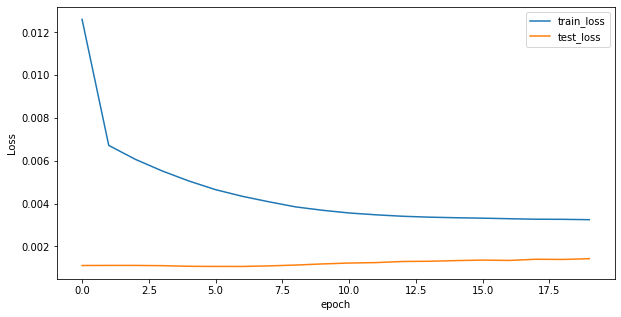

In [17]:
plt.figure(figsize=(10,5))
plt.plot(train_losses,label="train_loss")
plt.plot(test_losses,label="test_loss")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [28]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [12]:
def item_encoding(df):
    rating_df = df.copy()

    item_ids = rating_df['item'].unique()
    user_ids = rating_df['user'].unique()
    num_item, num_user = len(item_ids), len(user_ids)

    # user, item indexing
    item2idx = pd.Series(data=np.arange(len(item_ids)), index=item_ids) # item re-indexing (0~num_item-1)
    
    user2idx = pd.Series(data=np.arange(len(user_ids)), index=user_ids) # user re-indexing (0~num_user-1)

    # dataframe indexing
    rating_df = pd.merge(rating_df, pd.DataFrame({'item': item_ids, 'item_idx': item2idx[item_ids].values}), on='item', how='inner')
    rating_df = pd.merge(rating_df, pd.DataFrame({'user': user_ids, 'user_idx': user2idx[user_ids].values}), on='user', how='inner')
    rating_df.sort_values(['user_idx', 'time'], inplace=True)
    del rating_df['item'], rating_df['user']

    return rating_df

In [13]:
def train_valid_split():
    data_path = '../data/train'
    df = pd.read_csv(os.path.join(data_path, 'train_ratings.csv')) # 전체 학습 데이터
    df = item_encoding(df)

    items = df.groupby("user_idx")["item_idx"].apply(list)
    
    # {"user_id" : [items]} dict
    train_set, valid_set, item_set = {} , {}, {}
    print("train_valid set split by user_idx")

    for uid, item in enumerate(tqdm(items)):

        # 유저가 소비한 item의 12.5% 또는 최대 10 으로 valid_set 아이템 구성
        # num_u_valid_set = 10
        num_u_valid_set = min(int(len(item)*0.125), 10)
        u_valid_set = np.random.choice(item, size=num_u_valid_set, replace=False)
        
        train_set[uid] = list(set(item) - set(u_valid_set))
        valid_set[uid] = u_valid_set.tolist()
        item_set[uid] = list(set(item))

    return train_set, valid_set, item_set

In [14]:
print('train valid split')
train_set, valid_set, item_set = train_valid_split()

train valid split
train_valid set split by user_idx


100%|██████████| 31360/31360 [00:02<00:00, 13677.82it/s]


In [15]:
def make_interaction(*datasets):
    data_path = '../data/train'
    df = pd.read_csv(os.path.join(data_path, 'train_ratings.csv')) # 전체 학습 데이터
    df = item_encoding(df)

    num_users = df['user_idx'].nunique()
    num_items = df['item_idx'].nunique()

    mat_list = []
    dataset_list = datasets

    for dataset in dataset_list: 
        inter_mat = np.zeros((num_users, num_items))
        for uid, items in tqdm(dataset.items()):
            for item in items:
                inter_mat[uid][item] = 1
        mat_list.append(inter_mat)

    return mat_list

In [16]:
print('make csr matrix')
train_mat, valid_mat, item_mat = make_interaction(train_set, valid_set, item_set)

make csr matrix


100%|██████████| 31360/31360 [00:01<00:00, 17884.01it/s]


In [18]:
from torch.utils.data import Dataset
class AutoRecDataset(Dataset):
    def __init__(self, inter_mat, answers_mat):
        #self.args = args
        self.inter_mat = inter_mat
        self.answers = answers_mat.argsort(axis = 1)

        # valid data의 최소 길이
        # self.answers_minlen = min([len(answer) for answer in self.answers.values()])

    def __len__(self):
        return len(self.inter_mat)

    def __getitem__(self, index):
        user_id = index
        inter_mat = self.inter_mat[user_id]
        answers = self.answers[user_id][-10:]
       
        cur_tensors = (
            torch.tensor(user_id, dtype=torch.long),
            torch.tensor(inter_mat, dtype=torch.float),
            torch.tensor(answers, dtype=torch.long),
        )

        return cur_tensors

In [19]:
train_dataset = AutoRecDataset(item_mat, valid_mat)
eval_dataset = AutoRecDataset(train_mat, valid_mat)
submission_dataset = AutoRecDataset(item_mat, valid_mat)

In [26]:
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

num_epochs = 20
lr = 0.002
batch_size = 256

#num_users = df.user_idx.max() + 1
num_hidden = 500

In [27]:
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle = True, pin_memory = True
)

eval_dataloader = DataLoader(
    eval_dataset, batch_size=batch_size, shuffle = False, pin_memory = True
)

submission_dataloader = DataLoader(
    submission_dataset, batch_size=batch_size, shuffle = False, pin_memory = True
)

In [ ]:
""""self.encoder = nn.Linear(num_users, num_hidden)
        self.sigmoid = nn.Sigmoid()
        self.decoder = nn.Linear(num_hidden, num_users)
        self.dropout = nn.Dropout(dropout)""""

In [32]:
# AutoRec Model
class AutoRec(nn.Module):
    """
    AutoRec
    
    Args:
        - input_dim: (int) input feature의 Dimension
        - emb_dim: (int) Embedding의 Dimension
        - hidden_activation: (str) hidden layer의 activation function.
        - out_activation: (str) output layer의 activation function.
    Shape:
        - Input: (torch.Tensor) input features,. Shape: (batch size, input_dim)
        - Output: (torch.Tensor) reconstructed features. Shape: (batch size, input_dim)
    """
    def __init__(self):
        super(AutoRec, self).__init__()
        
        # initialize Class attributes
        #self.args = args
        """self.input_dim = self.args.input_dim
        self.emb_dim = self.args.hidden_size
        self.hidden_activation = self.args.hidden_activation
        self.out_activation = self.args.out_activation
        self.num_layers = self.args.num_layers
        self.dropout_rate = self.args.dropout_rate"""
        self.input_dim = 6807 #train_mat.shape[1]
        self.emb_dim = 64
        self.num_layers = 1
        self.dropout_rate = 0.05
        
        # define layers
        encoder_modules = list()
        encoder_layers = [self.input_dim] + [self.emb_dim // (2 ** i) for i in range(self.num_layers)]
        for i in range(self.num_layers):
            input_size = encoder_layers[i] 
            output_size = encoder_layers[i + 1] 
            encoder_modules.append(nn.Linear(input_size, output_size))
            activation_function = nn.Sigmoid()
            if activation_function is not None:
                encoder_modules.append(activation_function)
        encoder_modules.append(nn.Dropout(self.dropout_rate))
        
        decoder_modules = list()
        decoder_layers = encoder_layers[::-1]
        for i in range(self.num_layers):
            input_size = decoder_layers[i] 
            output_size = decoder_layers[i + 1] 
            decoder_modules.append(nn.Linear(input_size, output_size))
            activation_function = 'none'
            if activation_function is not None and (i < self.num_layers - 1):
                decoder_modules.append(activation_function)

        self.encoder = nn.Sequential(
            *encoder_modules
        )
        self.decoder = nn.Sequential(
            *decoder_modules
        )
        
        self.init_weights()

    # initialize weights
    def init_weights(self):
        for layer in self.encoder:
            if isinstance(layer, nn.Linear):
                torch.nn.init.xavier_normal_(layer.weight.data)
                layer.bias.data.zero_()
        
        for layer in self.decoder:
            if isinstance(layer, nn.Linear):
                torch.nn.init.xavier_normal_(layer.weight.data)
                layer.bias.data.zero_()

    
    def forward(self, input_feature):
        h = self.encoder(input_feature)
        output = self.decoder(h)
        
        return output

In [33]:
model = AutoRec()
trainer = AutoRecTrainer(
    model, train_dataloader, eval_dataloader, None, submission_dataloader, args
)
    
print(model)

In [ ]:
import numpy as np
import torch
from torchvision.utils import make_grid
from base import BaseTrainer
from utils import inf_loop, MetricTracker


class Trainer:
    def __init__(
        self,
        model,
        train_dataloader,
        eval_dataloader,
        test_dataloader,
        submission_dataloader,
        args,
    ):

        self.args = args
        self.cuda_condition = torch.cuda.is_available() and not self.args.no_cuda
        self.device = torch.device("cuda" if self.cuda_condition else "cpu")

        self.model = model
        if self.cuda_condition:
            self.model.cuda()

        # Setting the train and test data loader
        self.train_dataloader = train_dataloader
        self.eval_dataloader = eval_dataloader
        self.test_dataloader = test_dataloader
        self.submission_dataloader = submission_dataloader

        # self.data_name = self.args.data_name
        betas = (self.args.adam_beta1, self.args.adam_beta2)
        self.optim = Adam(
            self.model.parameters(),
            lr=self.args.lr,
            betas=betas,
            weight_decay=self.args.weight_decay,
        )

        print("Total Parameters:", sum([p.nelement() for p in self.model.parameters()]))
        self.criterion = nn.BCELoss()

    def train(self, epoch):
        self.iteration(epoch, self.train_dataloader)

    def valid(self, epoch):
        return self.iteration(epoch, self.eval_dataloader, mode="valid")

    def test(self, epoch):
        return self.iteration(epoch, self.test_dataloader, mode="test")

    def submission(self, epoch):
        return self.iteration(epoch, self.submission_dataloader, mode="submission")

    def iteration(self, epoch, dataloader, mode="train"):
        raise NotImplementedError

    def get_full_sort_score(self, epoch, answers, pred_list):
        recall, ndcg = [], []
        for k in [5, 10]:
            recall.append(recall_at_k(answers, pred_list, k))
            ndcg.append(ndcg_k(answers, pred_list, k))
        post_fix = {
            "Epoch": epoch,
            "RECALL@5": "{:.4f}".format(recall[0]),
            "NDCG@5": "{:.4f}".format(ndcg[0]),
            "RECALL@10": "{:.4f}".format(recall[1]),
            "NDCG@10": "{:.4f}".format(ndcg[1]),
        }
        print(post_fix)

        return [recall[0], ndcg[0], recall[1], ndcg[1]], str(post_fix)

    def save(self, file_name):
        torch.save(self.model.cpu().state_dict(), file_name)
        self.model.to(self.device)

    def load(self, file_name):
        self.model.load_state_dict(torch.load(file_name))

    def cross_entropy(self, seq_out, pos_ids, neg_ids):
        # [batch seq_len hidden_size]
        pos_emb = self.model.item_embeddings(pos_ids)
        neg_emb = self.model.item_embeddings(neg_ids)
        # [batch*seq_len hidden_size]
        pos = pos_emb.view(-1, pos_emb.size(2))
        neg = neg_emb.view(-1, neg_emb.size(2))
        seq_emb = seq_out.view(-1, self.args.hidden_size)  # [batch*seq_len hidden_size]
        pos_logits = torch.sum(pos * seq_emb, -1)  # [batch*seq_len]
        neg_logits = torch.sum(neg * seq_emb, -1)
        istarget = (
            (pos_ids > 0).view(pos_ids.size(0) * self.model.args.max_seq_length).float()
        )  # [batch*seq_len]
        loss = torch.sum(
            -torch.log(torch.sigmoid(pos_logits) + 1e-24) * istarget
            - torch.log(1 - torch.sigmoid(neg_logits) + 1e-24) * istarget
        ) / torch.sum(istarget)

        return loss

    def predict_full(self, seq_out):
        # [item_num hidden_size]
        test_item_emb = self.model.item_embeddings.weight
        # [batch hidden_size ]
        rating_pred = torch.matmul(seq_out, test_item_emb.transpose(0, 1))
        return rating_pred
    

class AutoRecTrainer(Trainer):
    def __init__(
        self,
        model,
        train_dataloader,
        eval_dataloader,
        test_dataloader,
        submission_dataloader,
        args,
    ):
        super(AutoRecTrainer, self).__init__(
            model,
            train_dataloader,
            eval_dataloader,
            test_dataloader,
            submission_dataloader,
            args,
        )

        self.loss_fn = nn.MSELoss().to(self.device)
        # self.loss_fn = nn.BCELoss().to(self.device)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optim,
            'min',
            factor = self.args.scheduler_factor,
            eps = self.args.scheduler_eps,
            patience = self.args.scheduler_patience,
            )

    def iteration(self, epoch, dataloader, mode="train"):

        # Setting the tqdm progress bar

        rec_data_iter = tqdm.tqdm(
            enumerate(dataloader),
            desc="Recommendation EP_%s:%d" % (mode, epoch),
            total=len(dataloader),
            bar_format="{l_bar}{r_bar}",
        )
        if mode == "train":
            self.model.train()
            rec_avg_loss = 0.0
            rec_cur_loss = 0.0

            for i, batch in rec_data_iter:
                # 0. batch_data will be sent into the device(GPU or CPU)
                batch = tuple(t.to(self.device) for t in batch)
                _, inter_mat, _ = batch

                pred = self.model(inter_mat)
                # pred -= pred.min(1, keepdim=True)[0]
                # pred /= pred.max(1, keepdim=True)[0]
                # print(pred)
                # break
                loss = self.loss_fn(pred, inter_mat)

                self.optim.zero_grad()
                loss.backward()
                self.optim.step()

                rec_avg_loss += loss.item()
                rec_cur_loss = loss.item()


            rec_avg_loss /= len(rec_data_iter)

            self.scheduler.step(rec_avg_loss)

            post_fix = {
                "epoch": epoch,
                "rec_avg_loss": "{:.4f}".format(rec_avg_loss),
                "rec_cur_loss": "{:.4f}".format(rec_cur_loss),
            }

            if (epoch + 1) % self.args.log_freq == 0:
                print(str(post_fix))

        else:
            self.model.eval()

            pred_list = None
            answer_list = None
            with torch.no_grad():
                for i, batch in rec_data_iter:
                    batch = tuple(t.to(self.device) for t in batch)
                    user_ids, inter_mat, answers = batch

                    rating_pred = self.model(inter_mat)
                    # rating_pred = rating_pred.softmax(dim = 1)
                    # print(rating_pred)
                    # break

                    rating_pred = rating_pred.cpu().data.numpy().copy()
                    batch_user_index = user_ids.cpu().numpy()
                    rating_pred[self.args.train_matrix[batch_user_index] > 0] = -1

                    ind = np.argpartition(rating_pred, -10)[:, -10:]
                    # ind = np.argpartition(rating_pred, -20)[:, -20:]

                    arr_ind = rating_pred[np.arange(len(rating_pred))[:, None], ind]

                    arr_ind_argsort = np.argsort(arr_ind)[np.arange(len(rating_pred)), ::-1]

                    batch_pred_list = ind[
                        np.arange(len(rating_pred))[:, None], arr_ind_argsort
                    ]

                    if i == 0:
                        pred_list = batch_pred_list
                        answer_list = answers.cpu().data.numpy()
                    else:
                        pred_list = np.append(pred_list, batch_pred_list, axis=0)
                        answer_list = np.append(
                            answer_list, answers.cpu().data.numpy(), axis=0
                        )

            if mode == "submission":
                return pred_list
            else:
                return self.get_full_sort_score(epoch, answer_list, pred_list)